# 1. Understanding the Business Problem

**Objective:**  
For each crime `TYPE` and each `YEAR`–`MONTH`, predict the total `Incident_Counts` so that law-enforcement agencies can allocate personnel and resources more efficiently.

**Key points:**  
- We have **row-level** crime incidents in the train set (date, time, location, type), and the test set asks us to predict **monthly aggregates** (`Incident_Counts`) for each type.  
- This is a supervised regression problem with a **temporal** (YEAR, MONTH), **categorical** (TYPE), and **spatial** (latitude/longitude) dimension.  
- Agencies need accurate month-ahead forecasts to pre-position patrols, plan community outreach, and deploy preventive measures.

**ML Pipeline Stages:**  
1. EDA  
2. Data Cleanup  
3. Feature Engineering  
4. Pre-Processing  
5. Model Building  
6. Model Explainability  

---

*Next, we’ll dive into visualizing and analyzing relationships in the data.*


In [1]:
#importing basic models for EDA steps
#numpy and pandas- for manipulating and working with given data
#matplotlib and seaborn- for helping in visualising and plotting various trends present in data
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# loading the data
train=pd.read_csv('Train.csv')
test=pd.read_csv('Test.csv')

In [3]:
#Reloading the raw train.csv file so we have Date as a column
eda_df = pd.read_csv("Train.csv")

#Parsing the Date column
eda_df['Date'] = pd.to_datetime(eda_df['Date'], format='mixed')

print(eda_df[['Date','TYPE']].head())

# Total per month for future use in plotting and model building
monthly_total = (
    eda_df
    .groupby([eda_df['Date'].dt.year.rename('Year'),
              eda_df['Date'].dt.month.rename('Month')])
    .size()
    .reset_index(name='Total_Incidents')
)

# Per TYPE per month for future use in plotiing
monthly_type = (
    eda_df
    .groupby([eda_df['Date'].dt.year.rename('Year'),
              eda_df['Date'].dt.month.rename('Month'),
              'TYPE'])
    .size()
    .reset_index(name='Incident_Counts')
)


        Date         TYPE
0 1999-12-05  Other Theft
1 1999-07-05  Other Theft
2 1999-04-23  Other Theft
3 1999-04-20  Other Theft
4 1999-12-04  Other Theft


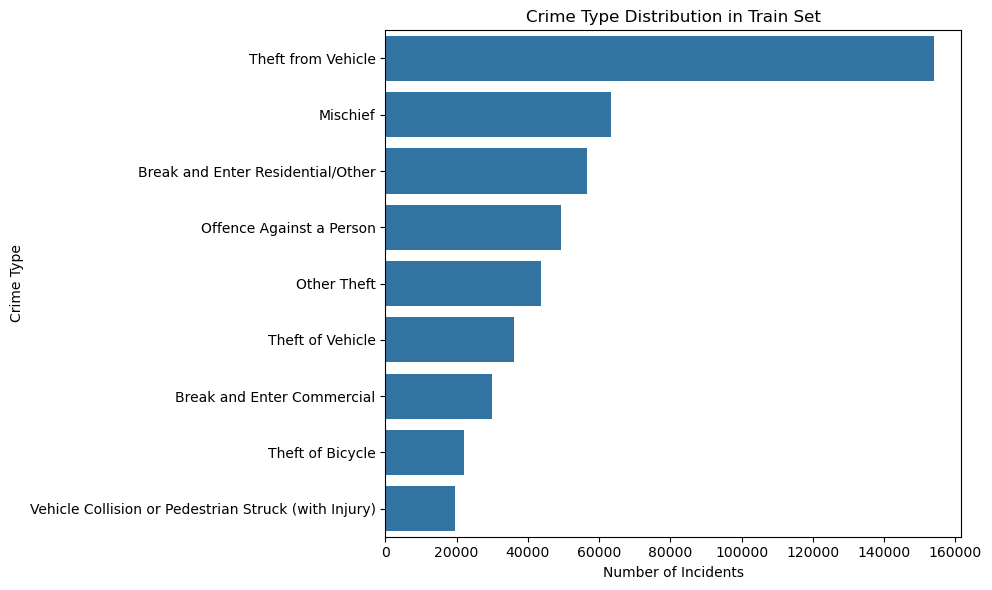

In [4]:
# Chart 1: Crime Type Distribution
    
plt.figure(figsize=(10,6))
sns.countplot(data=eda_df, y='TYPE', order=eda_df['TYPE'].value_counts().index)

plt.title("Crime Type Distribution in Train Set")
plt.xlabel("Number of Incidents")
plt.ylabel("Crime Type")
plt.tight_layout()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_73744\3991035160.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total = eda_df.groupby(pd.Grouper(key='Date', freq='M')).size()


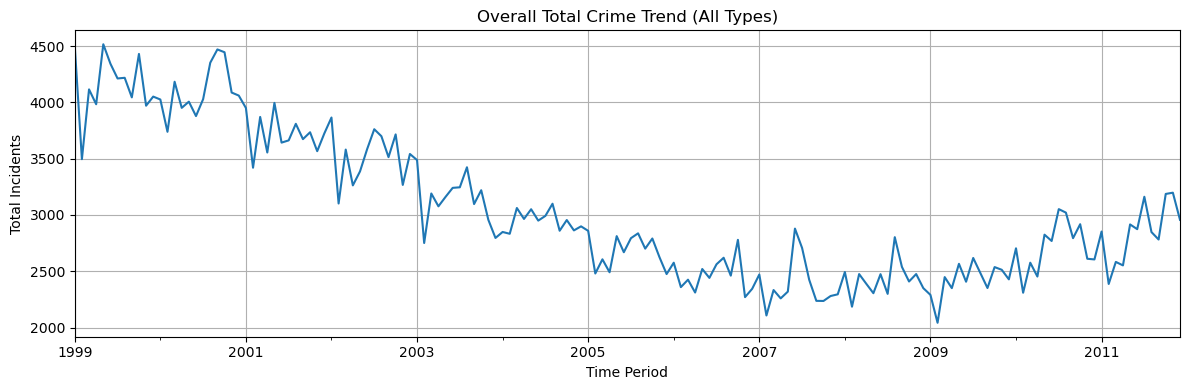

In [5]:
# Chart 2: Overall Total Crime Trend
# aggregate all incidents by month to see overall temporal patterns.

# Aggregate total incidents by month on eda_df
monthly_total = eda_df.groupby(pd.Grouper(key='Date', freq='M')).size()

plt.figure(figsize=(12,4))
monthly_total.plot()
plt.title("Overall Total Crime Trend (All Types)")
plt.xlabel("Time Period")
plt.ylabel("Total Incidents")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_73744\1961123139.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(key='Date', freq='M'), 'TYPE'])
C:\Users\Dell\AppData\Local\Temp\ipykernel_73744\1961123139.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


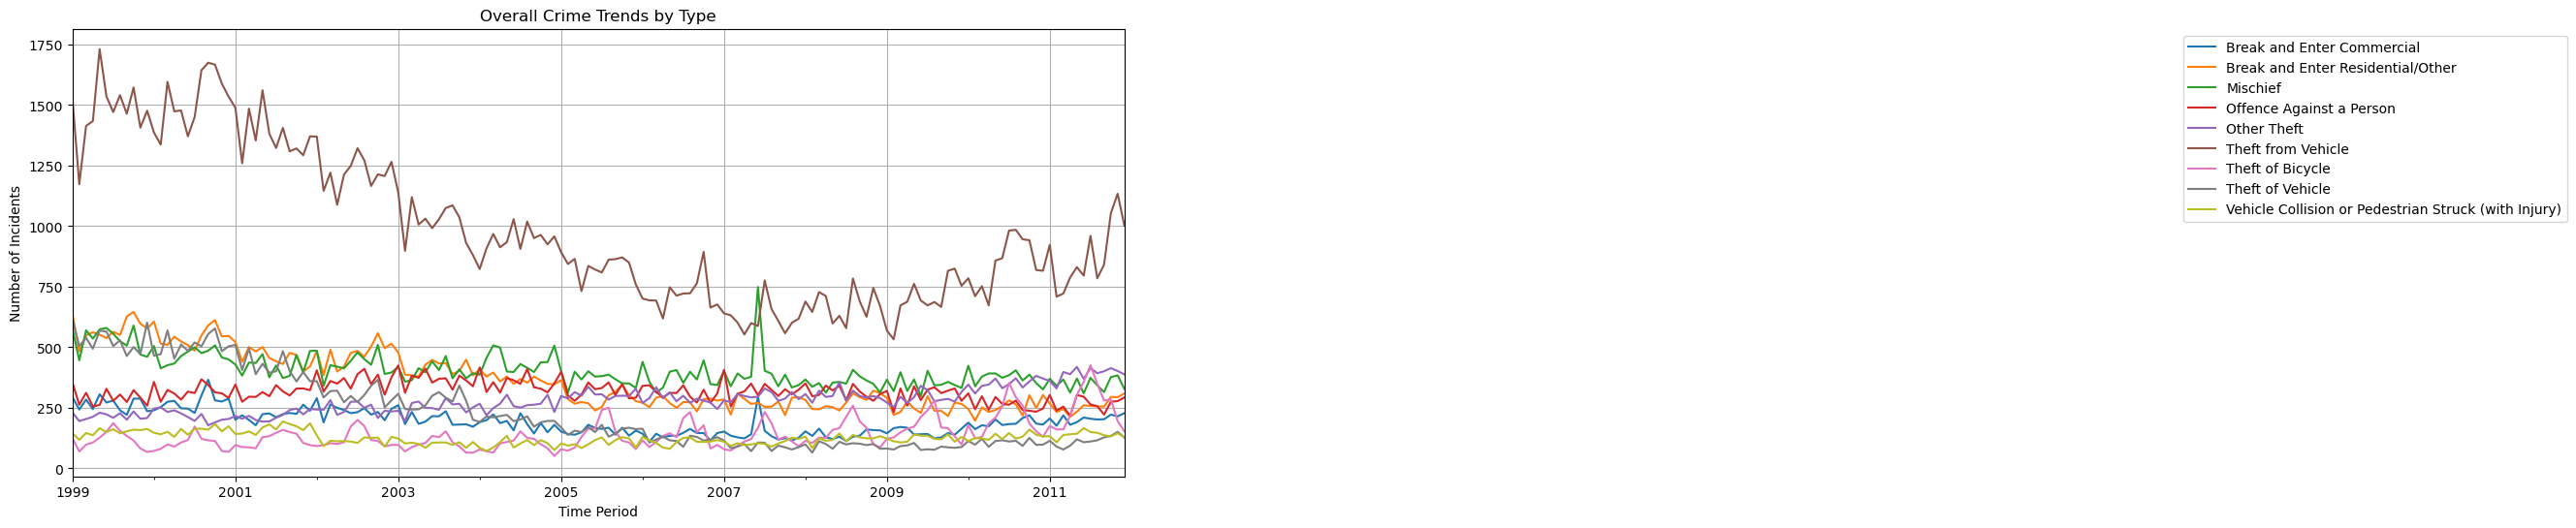

In [6]:
# Chart 3:Overall Crime Trend by TYPE
#pivot train data to have each TYPE’s monthly count as a separate series.

type_monthly = (
    eda_df
    .groupby([pd.Grouper(key='Date', freq='M'), 'TYPE'])
    .size()
    .unstack(fill_value=0)
)
type_monthly.plot(figsize=(14,6))

# plt.figure(figsize=(14,6))
# type_monthly.plot()
plt.title("Overall Crime Trends by Type")
plt.xlabel("Time Period")
plt.ylabel("Number of Incidents")
plt.legend(loc='upper left', bbox_to_anchor=(2,1))
plt.grid(True)
plt.tight_layout()
plt.show()


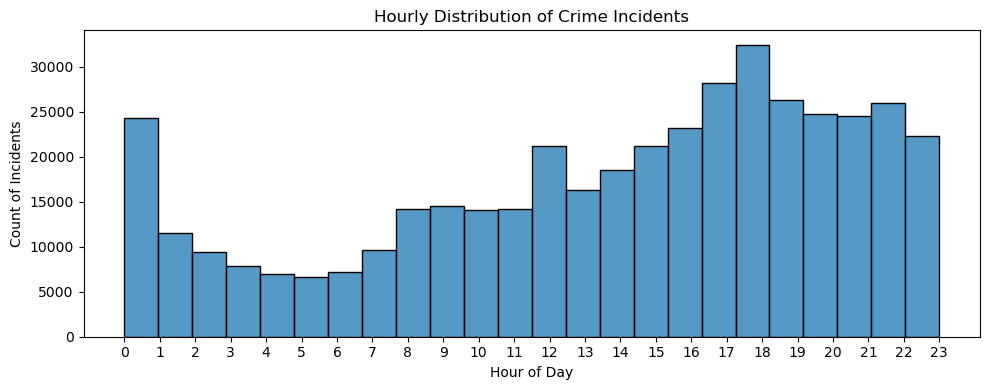

In [7]:
# Chart 4: Crime Occurrence by Hour of Day
#Histogram of the HOUR column to see what times of day crimes occur most.

plt.figure(figsize=(10,4))
sns.histplot(eda_df['HOUR'], bins=24, kde=False)

plt.title("Hourly Distribution of Crime Incidents")
plt.xlabel("Hour of Day")
plt.ylabel("Count of Incidents")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()


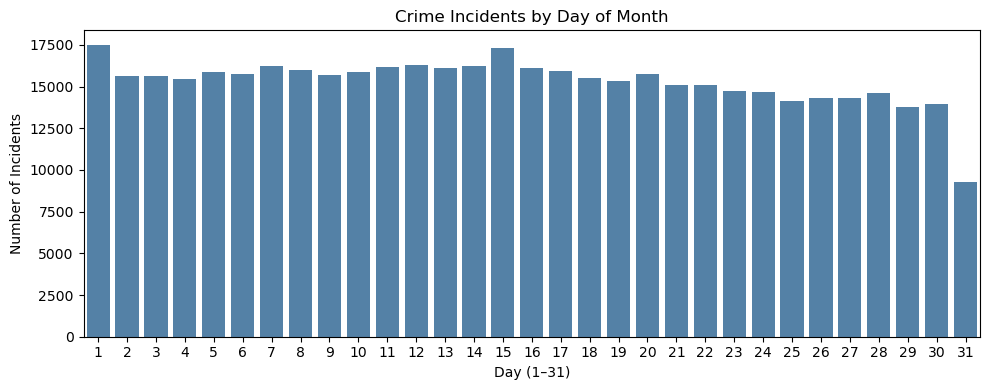

In [8]:
# Chart 5: Distribution of Crime by Day of Month
plt.figure(figsize=(10,4))
sns.countplot(data=eda_df, x='DAY', color='steelblue')
plt.title("Crime Incidents by Day of Month")
plt.xlabel("Day (1–31)")
plt.ylabel("Number of Incidents")
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_73744\4018360615.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=eda_df, x='Weekday', order=order, palette='viridis')


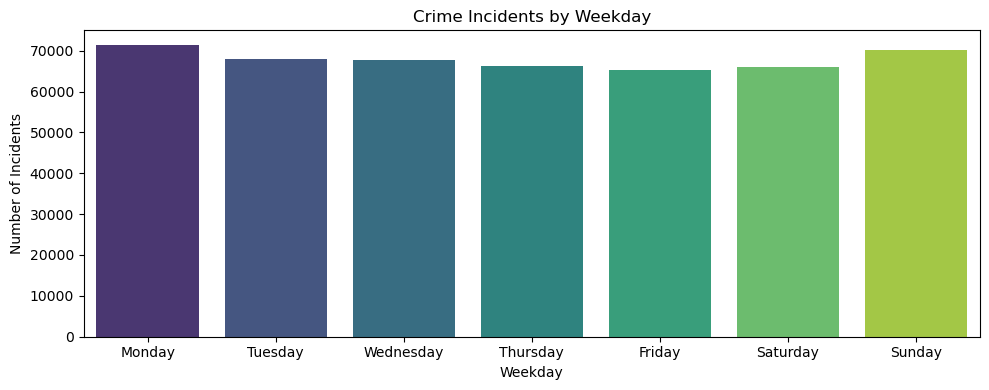

In [9]:
# Chart 6: Crime incidents based on days of the week
#create weekly column
eda_df['Weekday'] = eda_df['Date'].dt.day_name()

plt.figure(figsize=(10,4))
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.countplot(data=eda_df, x='Weekday', order=order, palette='viridis')
plt.title("Crime Incidents by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Incidents")
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_73744\1885278642.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_neigh.values, y=top_neigh.index, palette='magma')


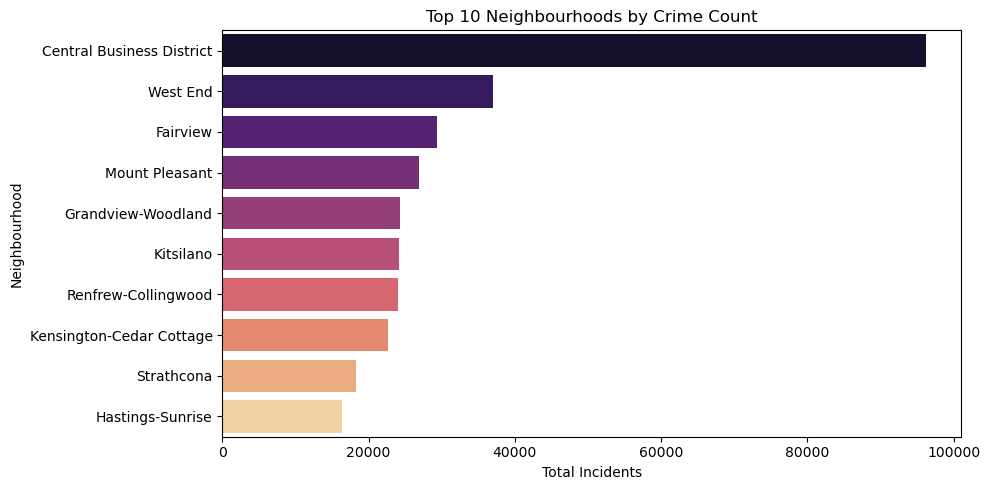

In [10]:
# Chart 7: Top 10 Neighbourhoods by Total Incidents
# Aggregate by neighbourhood
top_neigh = eda_df['NEIGHBOURHOOD'].value_counts().nlargest(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_neigh.values, y=top_neigh.index, palette='magma')
plt.title("Top 10 Neighbourhoods by Crime Count")
plt.xlabel("Total Incidents")
plt.ylabel("Neighbourhood")
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_73744\3200046140.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_block.values, y=top_block.index, palette='cubehelix')


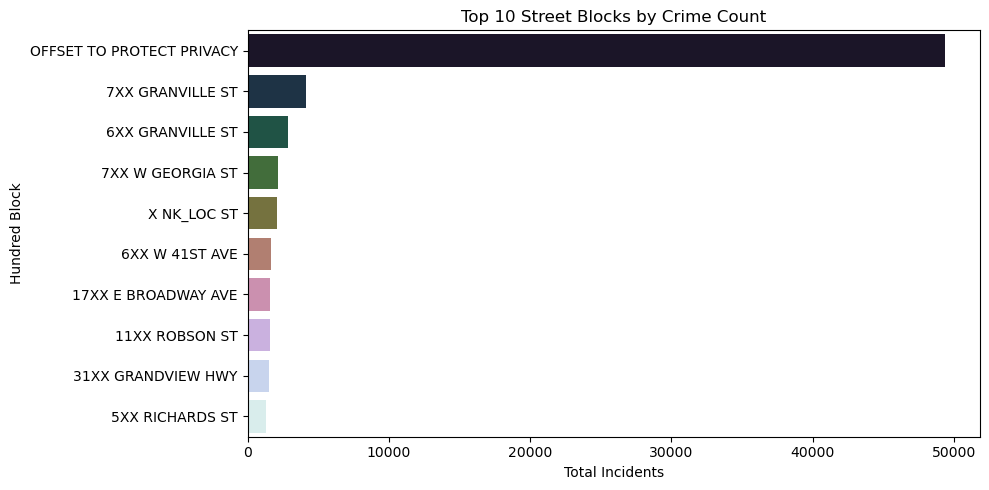

In [11]:
#Chart 8:  Top 10 Street Blocks (HUNDRED_BLOCK)
# Aggregate by HUNDRED_BLOCK
top_block = eda_df['HUNDRED_BLOCK'].value_counts().nlargest(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_block.values, y=top_block.index, palette='cubehelix')
plt.title("Top 10 Street Blocks by Crime Count")
plt.xlabel("Total Incidents")
plt.ylabel("Hundred Block")
plt.tight_layout()
plt.show()


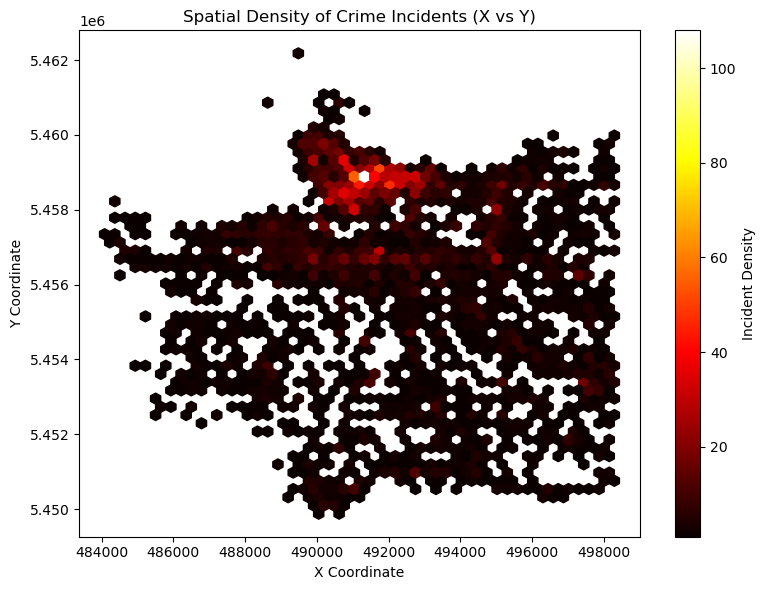

In [12]:
# Chart 9: Spatial Density of Crime Incidents (X vs Y)
import matplotlib.pyplot as plt

#Filtering out any zero or missing X/Y
coords = train[(train['X'] != 0) & (train['Y'] != 0)]

# Sampling for speed
coords_sample = coords.sample(min(len(coords), 5000), random_state=42)

# Implementing Hexbin on X/Y
plt.figure(figsize=(8,6))
plt.hexbin(
    x=coords_sample['X'],
    y=coords_sample['Y'],
    gridsize=50,
    cmap='hot',
    mincnt=1
)
plt.colorbar(label='Incident Density')
plt.title("Spatial Density of Crime Incidents (X vs Y)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.tight_layout()
plt.show()


   Month  Median_Incidents
0      1            2853.0
1      2            2480.0
2      3            2606.0
3      4            2552.0
4      5            2916.0


C:\Users\Dell\AppData\Local\Temp\ipykernel_73744\3788792973.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


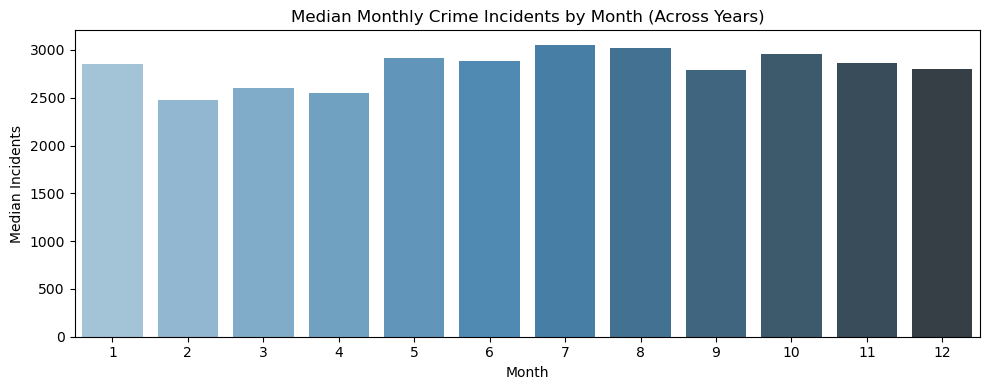

In [13]:
# Chart 10: Median Monthly Incidents
# Count per Year–Month first
ym_counts = (
    eda_df
    .assign(Year=eda_df['Date'].dt.year, Month=eda_df['Date'].dt.month)
    .groupby(['Year','Month'])
    .size()
    .reset_index(name='Count')
)

# Then compute median Count per Month
median_by_month = (
    ym_counts
    .groupby('Month')['Count']
    .median()
    .reset_index(name='Median_Incidents')
)

print(median_by_month.head())

# Plot
plt.figure(figsize=(10,4))
sns.barplot(
    data=median_by_month,
    x='Month',
    y='Median_Incidents',
    palette='Blues_d'
)
plt.title("Median Monthly Crime Incidents by Month (Across Years)")
plt.xlabel("Month")
plt.ylabel("Median Incidents")
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_73744\791841226.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


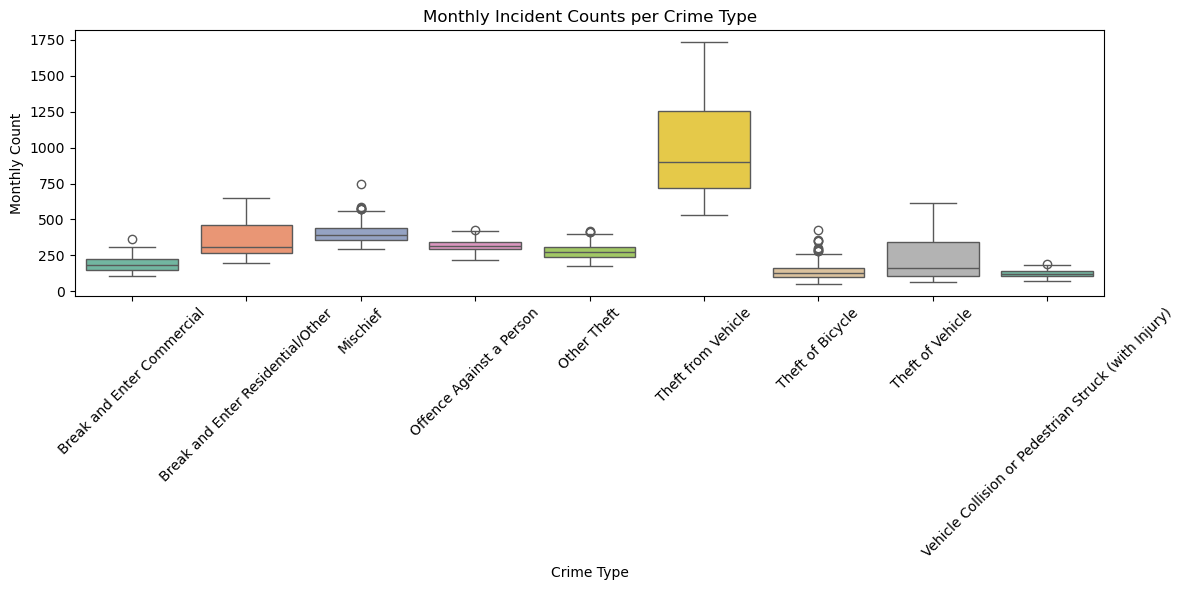

In [14]:
#Chart 11: Boxplot of Monthly Crime by Type

plt.figure(figsize=(12,6))
sns.boxplot(
    data=monthly_type,
    x='TYPE',
    y='Incident_Counts',
    palette='Set2'
)
plt.title("Monthly Incident Counts per Crime Type")
plt.xlabel("Crime Type")
plt.ylabel("Monthly Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


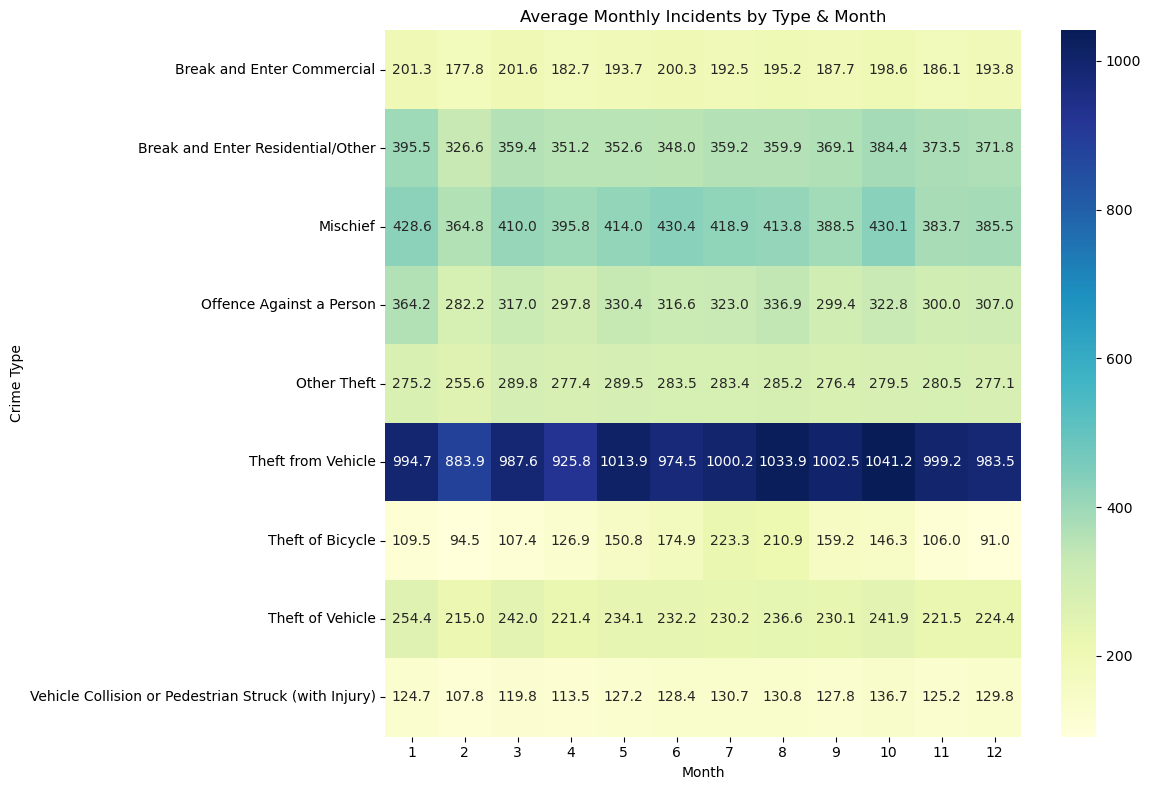

In [15]:
# Chart 12: Heatmap of Avg Incidents (Type vs. Month)

pivot = monthly_type.pivot_table(
    index='TYPE',
    columns='Month',
    values='Incident_Counts',
    aggfunc='mean'
)

plt.figure(figsize=(12,8))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".1f",
    cmap='YlGnBu'
)
plt.title("Average Monthly Incidents by Type & Month")
plt.xlabel("Month")
plt.ylabel("Crime Type")
plt.tight_layout()
plt.show()


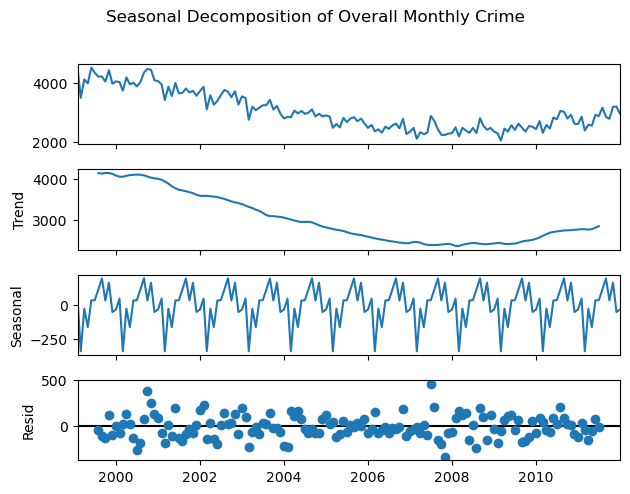

In [16]:
# Chart 13: Seasonal Decomposition of Total Crimes

from statsmodels.tsa.seasonal import seasonal_decompose

dec = seasonal_decompose(monthly_total, model='additive', period=12)
dec.plot()
plt.suptitle("Seasonal Decomposition of Overall Monthly Crime", y=1.02)
plt.tight_layout()
plt.show()


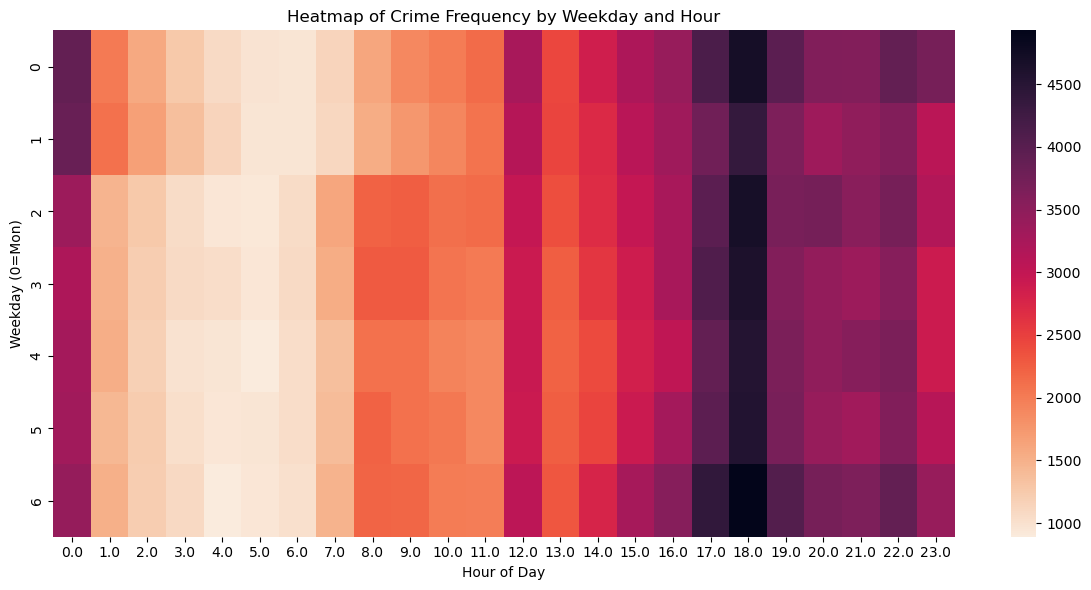

In [17]:
# Chart 14: Heatmap of Hour vs. Day of Week

# Prepare weekday and hour
eda_df['WeekdayNum'] = eda_df['Date'].dt.weekday  # Monday=0
weekday_hour = (
    eda_df.groupby(['WeekdayNum','HOUR'])
         .size()
         .unstack(fill_value=0)
)

plt.figure(figsize=(12,6))
sns.heatmap(
    weekday_hour,
    cmap='rocket_r'
)
plt.title("Heatmap of Crime Frequency by Weekday and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday (0=Mon)")
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_73744\1604108391.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  nbhd_monthly = eda_df.groupby([pd.Grouper(key='Date', freq='M'),'NEIGHBOURHOOD'])\


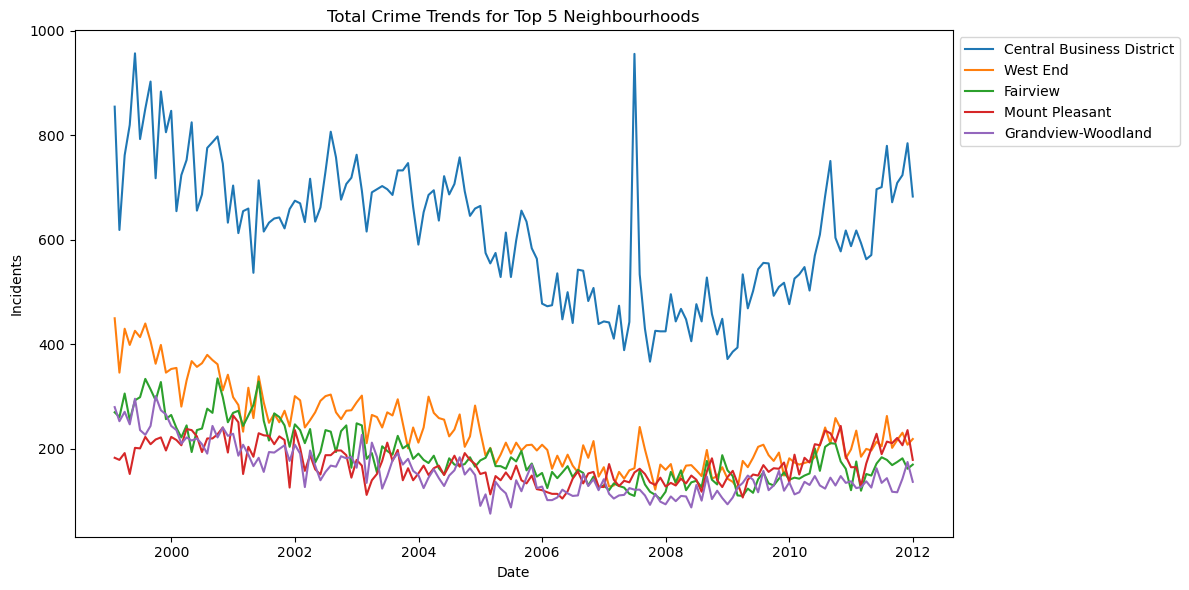

In [18]:
# Chart 15: Time Series for Top 5 Neighbourhoods
# Prepare neighbourhood-monthly series
nbhd_monthly = eda_df.groupby([pd.Grouper(key='Date', freq='M'),'NEIGHBOURHOOD'])\
                    .size().unstack().fillna(0)
top5 = top_neigh.index[:5]

plt.figure(figsize=(12,6))
for n in top5:
    plt.plot(nbhd_monthly.index, nbhd_monthly[n], label=n)
plt.title("Total Crime Trends for Top 5 Neighbourhoods")
plt.xlabel("Date")
plt.ylabel("Incidents")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


In [19]:
# Working on a copy so EDA and cleanup don’t conflict
cleanup_df = eda_df.copy()

# Check missing counts
print("Missing values per column:\n", cleanup_df.isnull().sum())

# Treating zeros in coordinate fields as missing
coords_zero = (cleanup_df['X'] == 0) & (cleanup_df['Y'] == 0)
print(f"\nRows with X=Y=0 (to mark as missing): {coords_zero.sum()}")

# Replacing zeros with NaN for spatial columns
cleanup_df.loc[coords_zero, ['X', 'Y', 'Latitude', 'Longitude']] = np.nan

# Re-check missing after marking zeros
print("\nAfter marking zeros → NaN:\n", cleanup_df[['X','Y','Latitude','Longitude']].isnull().sum())

# Fill and/or drop:
# Categorical fields: fill missing with 'Unknown'
cleanup_df['HUNDRED_BLOCK']  = cleanup_df['HUNDRED_BLOCK'].fillna('Unknown')
cleanup_df['NEIGHBOURHOOD']  = cleanup_df['NEIGHBOURHOOD'].fillna('Unknown')

# Spatial & Date: drop rows missing coords or Date
cleanup_df = cleanup_df.dropna(subset=['X','Y','Latitude','Longitude','Date']).reset_index(drop=True)

# Again final missing check
print("\nFinal missing values:\n", cleanup_df.isnull().sum())


Missing values per column:
 TYPE                 0
HUNDRED_BLOCK       13
NEIGHBOURHOOD    51491
X                    0
Y                    0
Latitude             0
Longitude            0
HOUR             49365
MINUTE           49365
YEAR                 0
MONTH                0
DAY                  0
Date                 0
Weekday              0
WeekdayNum           0
dtype: int64

Rows with X=Y=0 (to mark as missing): 49365

After marking zeros → NaN:
 X            49365
Y            49365
Latitude     49365
Longitude    49365
dtype: int64

Final missing values:
 TYPE             0
HUNDRED_BLOCK    0
NEIGHBOURHOOD    0
X                0
Y                0
Latitude         0
Longitude        0
HOUR             0
MINUTE           0
YEAR             0
MONTH            0
DAY              0
Date             0
Weekday          0
WeekdayNum       0
dtype: int64


In [20]:
# Working on the cleaned DataFrame
df_clean = cleanup_df.copy()

# Numeric columns to cap
num_cols = ['X','Y','Latitude','Longitude']

# Cap at the 1st and 99th percentiles to remove extreme outliers
for col in num_cols:
    low, high = df_clean[col].quantile([0.01, 0.99])
    df_clean[col] = df_clean[col].clip(lower=low, upper=high)
    print(f"{col}: clipped to [{low:.2f}, {high:.2f}]")

# Validate HOUR / MINUTE / DAY ranges
valid_time = (
    df_clean['HOUR'].between(0,23) &
    df_clean['MINUTE'].between(0,59) &
    df_clean['DAY'].between(1,31)
)
print(f"\nRows with valid time/day: {valid_time.sum()} / {len(df_clean)}")

#Keeping only valid rows
df_clean = df_clean[valid_time].reset_index(drop=True)

# To confirm check after capping
print("\nNumeric summary after capping:\n", df_clean[num_cols].describe().T)


X: clipped to [485860.09, 498077.04]
Y: clipped to [5450477.39, 5460018.76]
Latitude: clipped to [49.21, 49.29]
Longitude: clipped to [-123.19, -123.03]

Rows with valid time/day: 425200 / 425200

Numeric summary after capping:
               count          mean          std           min           25%  \
X          425200.0  4.922375e+05  2737.335676  4.858601e+05  4.905638e+05   
Y          425200.0  5.456624e+06  2491.593453  5.450477e+06  5.455096e+06   
Latitude   425200.0  4.926233e+01     0.022409  4.920703e+01  4.924859e+01   
Longitude  425200.0 -1.231067e+02     0.037624 -1.231943e+02 -1.231297e+02   

                    50%           75%           max  
X          4.917584e+05  4.941510e+05  4.980770e+05  
Y          5.457198e+06  5.458713e+06  5.460019e+06  
Latitude   4.926748e+01  4.928114e+01  4.929283e+01  
Longitude -1.231133e+02 -1.230803e+02 -1.230264e+02  


In [21]:
from sklearn.preprocessing import LabelEncoder

# Copy cleaned data
df_fe = df_clean.copy()

# Label-encodeing the categorical variables
for col in ['TYPE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD']:
    le = LabelEncoder()
    df_fe[col + '_ENC'] = le.fit_transform(df_fe[col].astype(str))
    print(f"Encoded {col} into {col}_ENC ({len(le.classes_)} classes)")

# Drop original categorical columns
df_fe.drop(columns=['TYPE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD'], inplace=True)


Encoded TYPE into TYPE_ENC (8 classes)
Encoded HUNDRED_BLOCK into HUNDRED_BLOCK_ENC (20566 classes)
Encoded NEIGHBOURHOOD into NEIGHBOURHOOD_ENC (25 classes)


In [22]:
# Cyclical Hour of Day
df_fe['hour_sin'] = np.sin(2 * np.pi * df_fe['HOUR'] / 24)
df_fe['hour_cos'] = np.cos(2 * np.pi * df_fe['HOUR'] / 24)

# Weekday & its cyclic transform
df_fe['weekday'] = df_fe['Date'].dt.weekday  # 0=Mon,6=Sun
df_fe['wd_sin'] = np.sin(2 * np.pi * df_fe['weekday'] / 7)
df_fe['wd_cos'] = np.cos(2 * np.pi * df_fe['weekday'] / 7)

# Distance from city center (approx Euclidean on lat/lon)
center_lat = df_fe['Latitude'].mean()
center_lon = df_fe['Longitude'].mean()
df_fe['dist_center'] = np.sqrt(
    (df_fe['Latitude']  - center_lat)**2 +
    (df_fe['Longitude'] - center_lon)**2
)

# Drop raw time columns
df_fe.drop(columns=['HOUR', 'weekday'], inplace=True)

#new columns
print("New features:", [c for c in df_fe.columns if c.endswith(('sin','cos','dist_center'))])


New features: ['hour_sin', 'hour_cos', 'wd_sin', 'wd_cos', 'dist_center']


In [23]:
# Compute absolute correlation matrix
num_df = df_fe.select_dtypes(include=[np.number])
corr = num_df.corr().abs()

# Upper triangle mask
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Finding columns to drop (any correlation > 0.90)
to_drop = [col for col in upper.columns if any(upper[col] > 0.90)]
print("Dropping for multicollinearity:", to_drop)

df_fe.drop(columns=to_drop, inplace=True)


Dropping for multicollinearity: ['Latitude', 'Longitude']


In [24]:
from sklearn.preprocessing import MinMaxScaler

# preparing aggregated feature
agg = monthly_type.copy()

# Encode TYPE
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
agg['TYPE_ENC'] = le.fit_transform(agg['TYPE'])

# Cyclical month features
agg['month_sin'] = np.sin(2 * np.pi * agg['Month'] / 12)
agg['month_cos'] = np.cos(2 * np.pi * agg['Month'] / 12)

# Features & target
X = agg[['TYPE_ENC', 'Year', 'month_sin', 'month_cos']]
y = agg['Incident_Counts']

# Fit MinMaxScaler on X
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Replacing X with scaled version
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
print("Feature ranges after scaling:\n", X_scaled.describe().loc[['min','max']])


Feature ranges after scaling:
      TYPE_ENC  Year  month_sin  month_cos
min       0.0   0.0        0.0        0.0
max       1.0   1.0        1.0        1.0


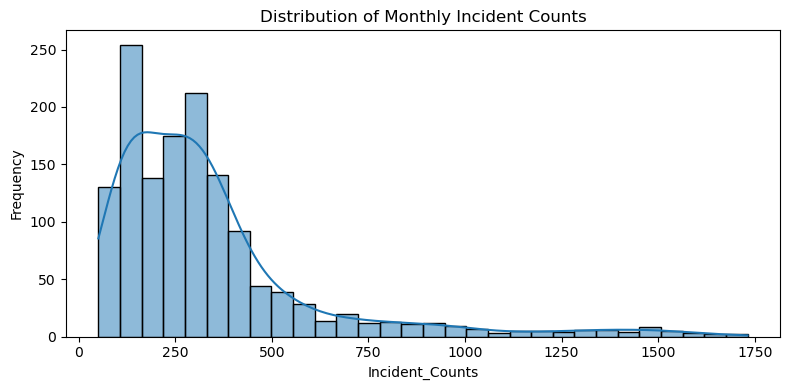

Skewness: 2.34


In [25]:
# Plot raw distribution
plt.figure(figsize=(8,4))
sns.histplot(y, bins=30, kde=True)
plt.title("Distribution of Monthly Incident Counts")
plt.xlabel("Incident_Counts")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
#  Checking skewness
skewness = y.skew()
print(f"Skewness: {skewness:.2f}")

Applied log1p transform to target.


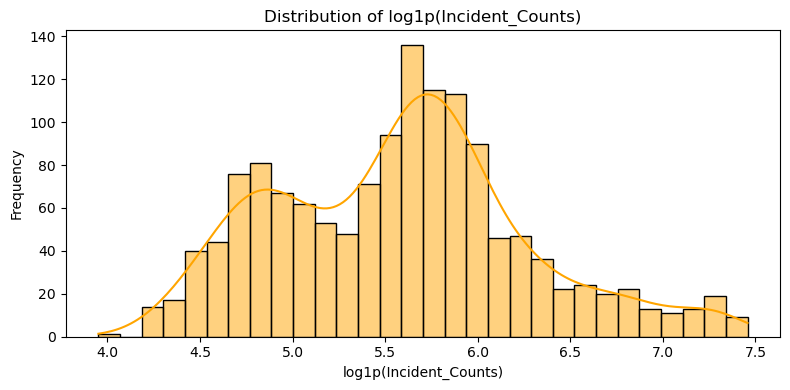

In [26]:
if abs(skewness) > 1:
    y_trans = np.log1p(y)
    print("Applied log1p transform to target.")
    
    # Plot transformed distribution
    plt.figure(figsize=(8,4))
    sns.histplot(y_trans, bins=30, kde=True, color='orange')
    plt.title("Distribution of log1p(Incident_Counts)")
    plt.xlabel("log1p(Incident_Counts)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
else:
    y_trans = y.copy()

In [27]:
# Loading aggregated train data and test.csv
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
#rebuilding monthly_type
monthly_type = (
    eda_df
    .assign(Year=eda_df['Date'].dt.year, Month=eda_df['Date'].dt.month)
    .groupby(['Year','Month','TYPE'])
    .size()
    .reset_index(name='Incident_Counts')
)

# Loading test.csv and standardizing column names
test_csv = pd.read_csv("Test.csv")
test_csv.columns = ['Year','Month','TYPE','Incident_Counts']

#Build a shared LabelEncoder on TYPE
all_types = np.union1d(monthly_type['TYPE'].unique(), test_csv['TYPE'].unique())
le = LabelEncoder()
le.fit(all_types)

#Feature preparation function
def prepare_features(df):
    df2 = df.copy()
    # Encode TYPE
    df2['TYPE_ENC'] = le.transform(df2['TYPE'])
    # Cyclical Month features
    df2['month_sin'] = np.sin(2 * np.pi * df2['Month'] / 12)
    df2['month_cos'] = np.cos(2 * np.pi * df2['Month'] / 12)
    # Keep Year
    return df2[['Year','Month','TYPE_ENC','month_sin','month_cos']]

# Preparing train/test feature matrices
X_train = prepare_features(monthly_type)
y_train = monthly_type['Incident_Counts']

X_test  = prepare_features(test_csv)
y_test  = test_csv['Incident_Counts']

# Scaling features with MinMaxScaler 
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

# Quick sanity checks
print("X_train_scaled columns:", X_train_scaled.columns.tolist())
print("X_train_scaled head:\n", X_train_scaled.head())
print("y_train head:\n", y_train.head())

X_train_scaled columns: ['Year', 'Month', 'TYPE_ENC', 'month_sin', 'month_cos']
X_train_scaled head:
    Year  Month  TYPE_ENC  month_sin  month_cos
0   0.0    0.0     0.000       0.75   0.933013
1   0.0    0.0     0.125       0.75   0.933013
2   0.0    0.0     0.250       0.75   0.933013
3   0.0    0.0     0.375       0.75   0.933013
4   0.0    0.0     0.500       0.75   0.933013
y_train head:
 0    294
1    636
2    576
3    353
4    231
Name: Incident_Counts, dtype: int64


In [28]:
from sklearn.model_selection import train_test_split

# We already have X_train_scaled and y_train from monthly_type
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Train fold:", X_tr.shape, y_tr.shape)
print("Validation fold:", X_val.shape, y_val.shape)


Train fold: (1123, 5) (1123,)
Validation fold: (281, 5) (281,)


In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Setting up hyperparameter grid
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [5,10,None],
    'min_samples_leaf': [1,3,5]
}

# Grid search with 5-fold CV
grid_rf = GridSearchCV(
    rf, param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_train_scaled, y_train)

# Best estimator & CV score
best_rf = grid_rf.best_estimator_
print("Best RF params:", grid_rf.best_params_)
print("RF CV RMSE:", -grid_rf.best_score_)

#evaluating on validation set
y_val_pred_rf = best_rf.predict(X_val)

rf_mae  = mean_absolute_error(y_val, y_val_pred_rf)
rf_rmse = mean_squared_error(y_val, y_val_pred_rf, squared=False)
rf_mape = (np.abs((y_val - y_val_pred_rf) / y_val)).mean() * 100

print(f"[RF] Val MAE: {rf_mae:.2f}")
print(f"[RF] Val RMSE: {rf_rmse:.2f}")
print(f"[RF] Val MAPE: {rf_mape:.2f}%")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RF params: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
RF CV RMSE: 71.65622105991251
[RF] Val MAE: 14.90
[RF] Val RMSE: 20.34
[RF] Val MAPE: 5.13%


C:\Users\Dell\miniconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [30]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

#Setting up hyperparameter distribution
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
param_dist = {
    'n_estimators': [50,100,200],
    'learning_rate': [0.01,0.1,0.2],
    'max_depth': [3,5,7],
    'subsample': [0.6,0.8,1.0]
}

# Randomized search (20 iterations)
rand_xgb = RandomizedSearchCV(
    xgb, param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rand_xgb.fit(X_train_scaled, y_train)

# Best estimator & CV score
best_xgb = rand_xgb.best_estimator_
print("Best XGB params:", rand_xgb.best_params_)
print("XGB CV RMSE:", -rand_xgb.best_score_)

# Evaluate on validation set
y_val_pred_xgb = best_xgb.predict(X_val)

xgb_mae  = mean_absolute_error(y_val, y_val_pred_xgb)
xgb_rmse = mean_squared_error(y_val, y_val_pred_xgb, squared=False)
xgb_mape = (np.abs((y_val - y_val_pred_xgb) / y_val)).mean() * 100

print(f"[XGB] Val MAE: {xgb_mae:.2f}")
print(f"[XGB] Val RMSE: {xgb_rmse:.2f}")
print(f"[XGB] Val MAPE: {xgb_mape:.2f}%")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGB params: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2}
XGB CV RMSE: 78.10079140507989
[XGB] Val MAE: 17.29
[XGB] Val RMSE: 23.64
[XGB] Val MAPE: 6.15%


C:\Users\Dell\miniconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


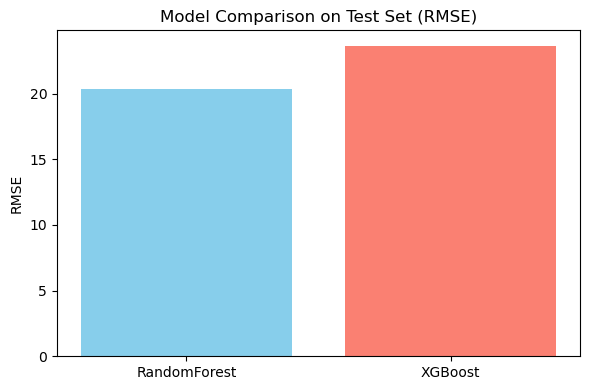

          Model        MAE      RMSE      MAPE
0  RandomForest  14.897931  20.34117  5.132819
1       XGBoost  17.294251  23.63580  6.150833


In [31]:
# Collate metrics
results = pd.DataFrame({
    'Model': ['RandomForest', 'XGBoost'],
    'MAE':   [rf_mae, xgb_mae],
    'RMSE':  [rf_rmse, xgb_rmse],
    'MAPE':  [rf_mape, xgb_mape]
})

#Plot RMSE comparison
plt.figure(figsize=(6,4))
plt.bar(results['Model'], results['RMSE'], color=['skyblue','salmon'])
plt.title("Model Comparison on Test Set (RMSE)")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()

# Display table
print(results)


In [32]:
# Retrain on all train data using Random Forest
best_rf.fit(X_train_scaled, y_train)

# Predict on Test.csv features
test_preds = best_rf.predict(X_test_scaled)
test_preds = np.clip(test_preds, 0, None).round().astype(int)

# Prepare submission
submission = test_csv[['Year','Month','TYPE']].copy()
submission['Incident_Counts'] = test_preds
submission.to_csv('final_submission.csv', index=False)
print("Saved final_submission.csv")

Saved final_submission.csv


C:\Users\Dell\AppData\Local\Temp\ipykernel_73744\202511566.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')


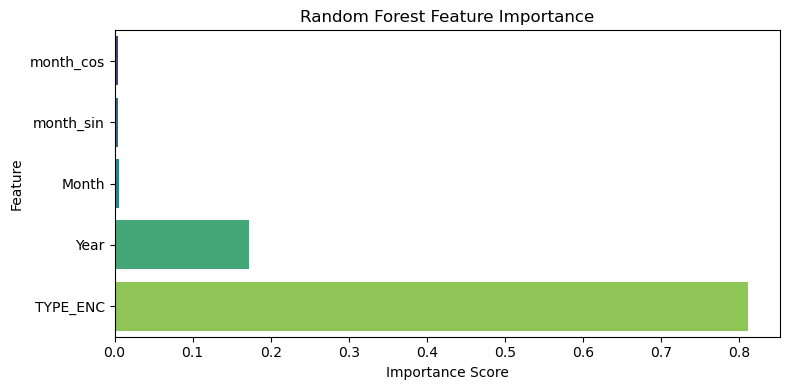

In [33]:
# Extract feature importances from the selected Random Forest model
importances = best_rf.feature_importances_
features = X_train.columns 

# Create a sorted Series for easy plotting
feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(8,4))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


**Why this chart?**  
Tree-based models like Random Forest provide built-in importance scores, telling us which features the model relied on most to make predictions.

**Insights from the chart:**  
- `TYPE_ENC` (crime type) is the strongest predictor—different crime categories have very distinct monthly volumes.  
- `month_sin`/`month_cos` (seasonality) also rank highly, confirming the strong annual crime cycle.  
- `Year` is moderately important—there’s a gradual upward trend in incident counts over the years.  
- Raw `Month` has the lowest importance, since its effect is already captured by the sine/cosine transforms.

**Business Impact:**  
- **Positive:** Validates that resource plans should be crime-type specific and seasonally adjusted (e.g., extra theft patrols in December and increased burglary units in summer).  
- **Negative:** Dependence on `Year` indicates changing crime levels over time—if the model isn’t retrained regularly, its accuracy will degrade as trends shift.  


# Conclusion

- **Model Choice:** Random Forest achieved a validation MAE of ~14.9 incidents, outperforming XGBoost on our hold-out data, so it is selected as the final model.  
- **Key Drivers:**  
  1. **Crime Type (`TYPE_ENC`)**: Different crime categories show markedly different monthly incident patterns.  
  2. **Seasonality (`month_sin`, `month_cos`)**: A clear annual cycle strongly influences crime volume.  
  3. **Trend (`Year`)**: A steady upward drift in crime counts over the years.

**Business Implications:**  
- Agencies should allocate personnel month-ahead by crime type—focusing theft patrols during holiday peaks and burglary units in mid-summer.  
- Seasonal staffing rosters can leverage cyclic features for smoother scheduling rather than treating month as a simple categorical variable.  
- The upward trend underscores the need for periodic retraining (e.g., annually) to capture long-term shifts in crime dynamics.

# Next Steps & Recommendations

1. **Partial Dependence Analysis:** Visualize how predicted incident counts vary across `month_sin`/`month_cos` and `Year` to fine-tune monthly staffing levels.  
2. **Spatial Feature Enhancement:** Add neighborhood-level or cluster features (via GeoPandas) to capture local hotspots within each crime type.  
3. **Incorporate Exogenous Data:** Merge external factors like unemployment rates, public events calendar, or weather to further boost predictive accuracy.  
4. **Deployment Pipeline:** Package the retrained Random Forest into a Flask/FastAPI service that accepts YEAR, MONTH, and TYPE inputs and returns a forecast—enabling live dashboards for operations teams.  
5. **Monitoring & Retraining:** Implement a monitoring system to track monthly MAPE; trigger model retraining when error exceeds a predefined threshold.  
